**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 2 Clustering Analysis**

## **Import the libraries and load the player dataset**

First we have to import the necessary libraries to work within our project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import math
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

The dataset coming from the data preparation task is saved on github.

In [ ]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

fatal: destination path 'DataMiningProject' already exists and is not an empty directory.


**Load the players' profile dataset**

In [ ]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,"[21,27]",>190,top 10
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,>34,>190,top 1000
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,>34,"[181,190]",top 500
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,>34,"[181,190]",top 250
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,>34,"[171,180]",top 1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,182,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16,"[28,34]","[181,190]",top 1000
4254,david o hare,M,27,IRL,184,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0,"[21,27]","[181,190]",top 1000
4255,kuan-yi lee,M,23,TWN,173,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42,"[21,27]","[171,180]",top 1000
4256,ben patael,M,22,ISR,192,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45,"[21,27]",>190,top 1000


In [ ]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             1600 non-null   object  
 1   sex              1600 non-null   object  
 2   age              1600 non-null   Int32   
 3   ioc              1600 non-null   object  
 4   ht               1600 non-null   Int32   
 5   hand             1600 non-null   object  
 6   t_won            1600 non-null   Int32   
 7   p_wins           1600 non-null   float64 
 8   wins             1600 non-null   Int32   
 9   p_w_Hard         1600 non-null   float64 
 10  w_Hard           1600 non-null   Int32   
 11  p_w_Clay         1600 non-null   float64 
 12  w_Clay           1600 non-null   Int32   
 13  p_w_Grass        1600 non-null   float64 
 14  w_Grass          1600 non-null   Int32   
 15  p_aces           1600 non-null   float64 
 16  p_double_faults  1600 non-null   float64 


##**Choosing the features and normalization**

Before we apply any clustering algorithm we need to choose the features that we think are the best at describing the players. Then we apply normalization on such features.

We decided to consider mainly the percentages since they describe better the player's attitude on the field (albeit they aren't as much as robust). Since there are a lot of feature, with many of them unrelated, we decided to build three different dataframe to work on during the clustering analysis plus a fourth one which contains all the features.

In [ ]:
# retrieve only the numerical features
df_players_numerical = df_players.select_dtypes(["int32", "Int32", "float64"])

# build the dataframe for the clustering analysis
df_clustering_0 = df_players_numerical[["t_won", "p_wins", "rank"]]  # cluster about the strenght of a player
df_clustering_1 = df_players_numerical[["p_w_Hard", "p_w_Clay", "p_w_Grass"]]  # cluster about the performance
df_clustering_2 = df_players_numerical[["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won"]]  # cluster about the playstyle of the player
df_clustering_3 = df_players_numerical  # cluster for all the feature
df_clusters = [df_clustering_0, df_clustering_1, df_clustering_2, df_clustering_3]

We decided to normalize such features with their z-score by using the scikit-learn StandardScaler.

In [ ]:
scaler = StandardScaler()  # z-score scaler
x_clusters = []
df_clusters_scaled = []
for df_clustering in df_clusters:
    x = scaler.fit_transform(df_clustering.values)
    df_clustering_scaled = pd.DataFrame(x, columns=df_clustering.columns, index=df_clustering.index)
    x_clusters.append(x)
    df_clusters_scaled.append(df_clustering_scaled)

df_clusters_scaled[0]

,t_won,p_wins,rank
0,7.367218,2.014899,-1.130862
8,-0.439752,0.084832,1.012741
13,-0.439752,0.619264,-0.276472
14,-0.439752,-1.125868,-0.512955
15,-0.439752,-0.519343,0.768630
...,...,...,...
4253,-0.439752,0.685872,0.961885
4254,-0.439752,-1.386815,4.504044
4255,-0.439752,0.210995,0.313464
4256,-0.439752,-0.261530,0.285493


Let's plot the first three dataframes.

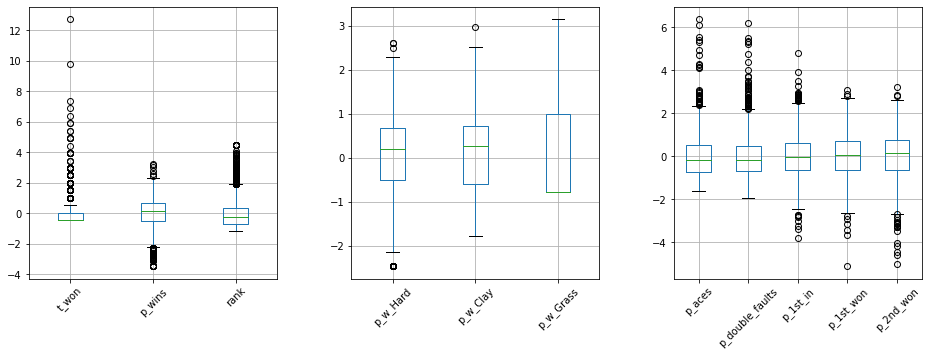

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
df_clusters_scaled[0].boxplot(list(df_clusters_scaled[0].columns), rot=45, ax=ax0)
df_clusters_scaled[1].boxplot(list(df_clusters_scaled[1].columns), rot=45, ax=ax1)
df_clusters_scaled[2].boxplot(list(df_clusters_scaled[2].columns), rot=45, ax=ax2)
fig.subplots_adjust(wspace=0.3)

Now the last dataframe, the one that contains all the features.

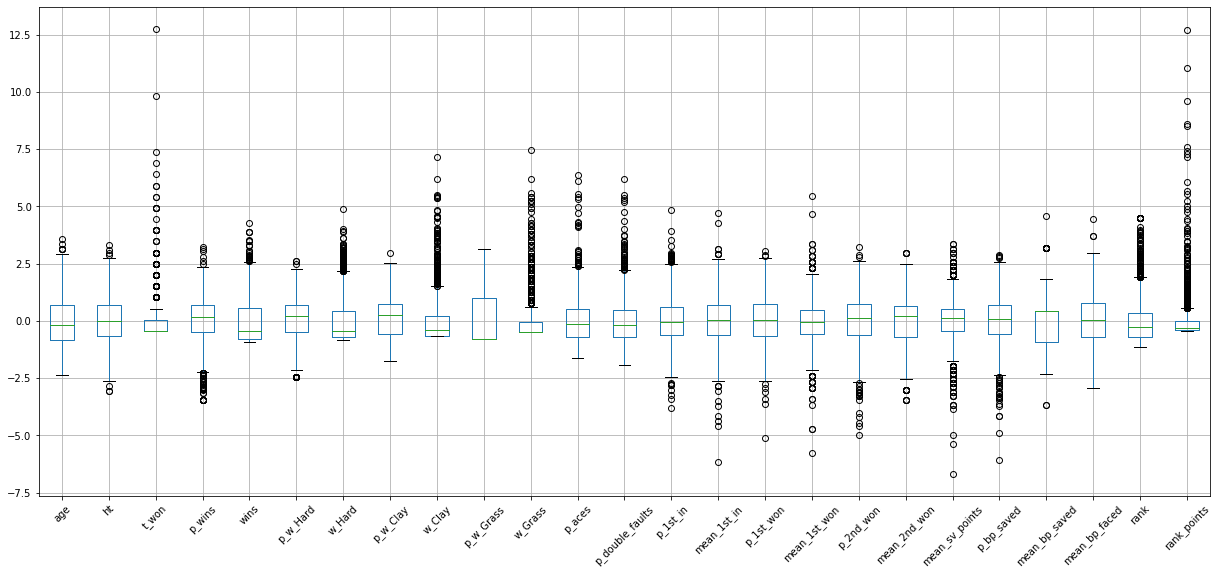

In [ ]:
df_clusters_scaled[3].boxplot(list(df_clusters_scaled[3].columns), rot=45, figsize=(21, 9));

## **K-means**

We run the k-means algorithm and we chose the best number of clusters based on the three indicators (the ones which we've seen during lesson), then we analize the results obtained.

### **Clustering on the first dataframe ["t_won", "p_wins", "rank"]**

**Indicators:**

*   **SSE Score** (Inertia): Sum of squared error
*   **Silhouette Score**: It combines both cohesion and separation. Cluster cohesion measures how closely related are objects in a cluster. Typically between 0 and 1, the closer to 1 the better.
*   **Davies Bouldin Score**: It is defined as a ratio of within cluster scatter and the between cluster separation. (Positive indicator, lower value closer to 0 is better).

In [ ]:
def k_means(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

Calculate the SSE, Silhoutte and Davies-Bouldin score for each dataframe.

In [ ]:
sse_clusters = list()
sil_clusters = list()
davies_clusters = list()
for i, x_cluster in enumerate(x_clusters):
    # print(x_cluster)
    sse, sil, davies_bouldin = k_means(x_cluster, i, 20)
    sse_clusters.append(sse)
    sil_clusters.append(sil)
    davies_clusters.append(davies_bouldin)

Dataframe 0, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 1, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 2, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 3, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Plot the indicators values for each k.

In [ ]:
def plot_indicators(i_cluster, max_k, sse_list, sil_list, davies_list):

    # plot indicators
    fig, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Dataframe {0}, indicators".format(i_cluster), fontsize=22)

Let's focus on the first dataframe for now, the one with ["t_won", "p_wins", "rank"].

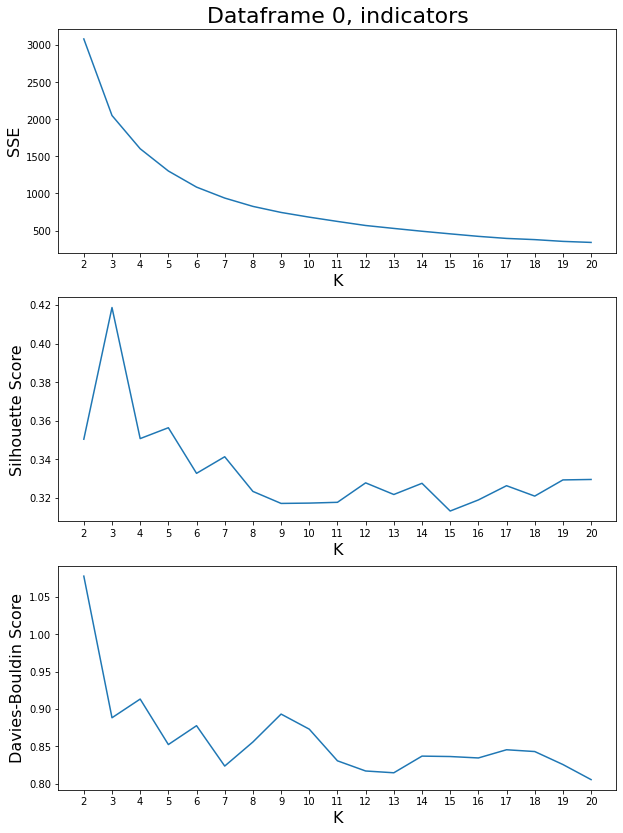

In [ ]:
plot_indicators(0, 20, sse_clusters[0], sil_clusters[0], davies_clusters[0])

By using the elbow rule for the SSE graph and looking at the other two, we saw that the best value for k is 3, we proceed with our analysis.

In [ ]:
k = 3  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[0])
print("SSE:", sse_clusters[0][k-2], " - SILHOUETTE:", sil_clusters[0][k-2])

SSE: 2050.105646746996  - SILHOUETTE: 0.4186592739338631


Let's see how many players are in each cluster.

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 375, 1: 1011, 2: 214}


**Using Similarity Matrix for Cluster Validation**: if we have well-separated clusters, then the similarity matrix should be
roughly block-diagonal 

In [ ]:
def plot_similarity_heatmap(df, labels):
    df_plot = pd.DataFrame(df, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]
    df_plot.sort_values(by='cluster', ascending=False, inplace=True)
    dist = euclidean_distances(df_plot.loc[:, columns], df_plot.loc[:, columns])
    sim = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(12,8))
    sn.heatmap(sim, ax=ax, cmap='coolwarm')

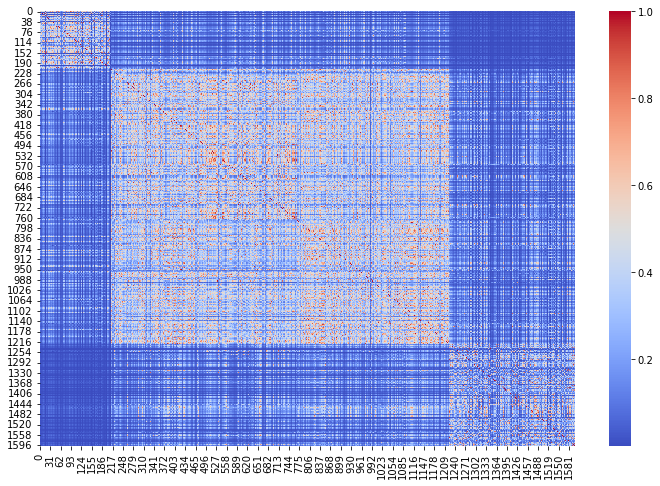

In [ ]:
clusters_players = kmeans.labels_
plot_similarity_heatmap(df_clusters_scaled[0], clusters_players)

#### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Let's take the players with the most tourneys won.

In [ ]:
df_players[df_players["t_won"]==df_players["t_won"].max()]

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
255,novak djokovic,M,34,SRB,188,R,27,85.45,282,85.86,164,82.18,83,92.11,35,6.84,3.23,65.46,51,74.58,38,55.49,14,77,65.65,3,4,1,12113,"[28,34]","[181,190]",top 10


We now plot the clusters using the PCA.

Text(255    6.630078
Name: PC_1, dtype: float64, 255    8.452943
Name: PC_2, dtype: float64, 'novak djokovic')

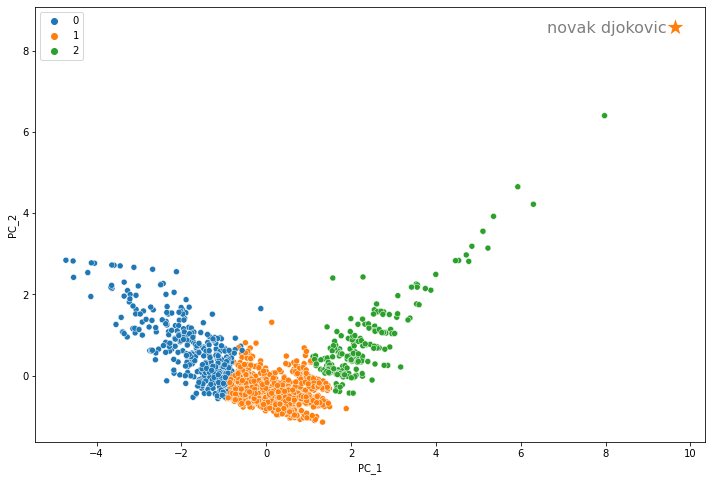

In [ ]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[0]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

In [ ]:
def plot_basic_statistics(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(14,8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i, columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)  
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        plt.plot(range(0, columns.shape[0]), means[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=55)

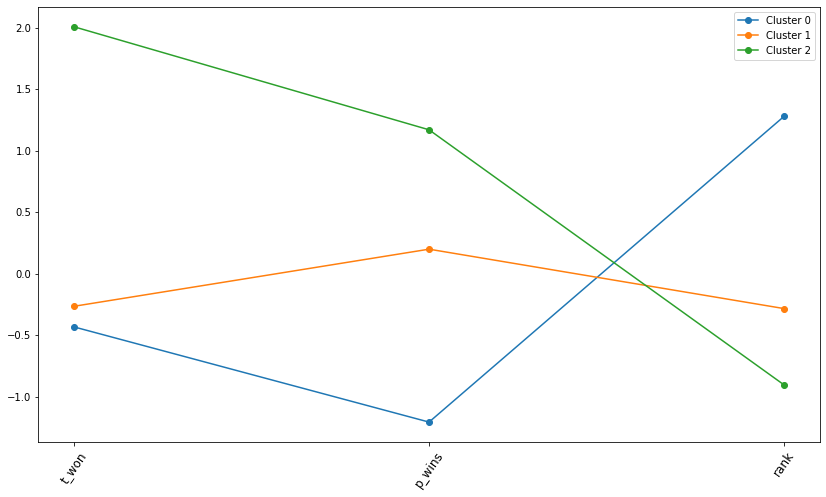

In [ ]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[0], clusters_players, df_clusters_scaled[0].columns)

From what we can see, cluster 2 contains the best players, meanwhile cluster 1 contains those with an high percentage of wins but less tourneys won (those are probably players from the top25 to top100 in the rankings), cluster 0 contains all the remaining players.

In [ ]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,t_won,p_wins,rank
cluster,,,
0,0.016000,28.985307,952.824000
1,0.359050,46.913966,338.335312
2,5.014019,59.291589,94.373832


In [ ]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")
df_cluster_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   t_won    1600 non-null   float64
 1   p_wins   1600 non-null   float64
 2   rank     1600 non-null   float64
 3   cluster  1600 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 136.2 KB


The means we calculated for each cluster confirm our assumptions on the clustering (i.e.: cluster 1 contains the best current players).

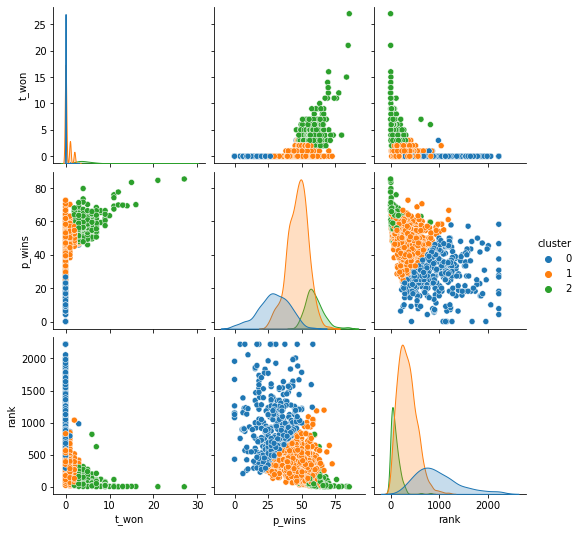

In [ ]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

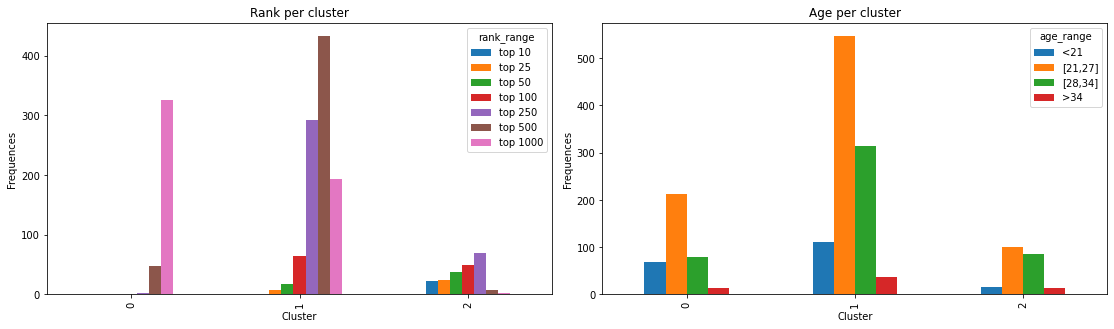

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

From the last two graphs we can see how the best players fall in the same cluster (labeled with 2) and they are mostly in the 21 to 34 age range (which is the usal peak for a tennis player).

### **Test k-kmeans with other features**

We still have to test k-means with the remaining three dataframes.

#### **Clustering on the second dataframe ["p_w_Hard", "p_w_Clay", "p_w_Grass"]**

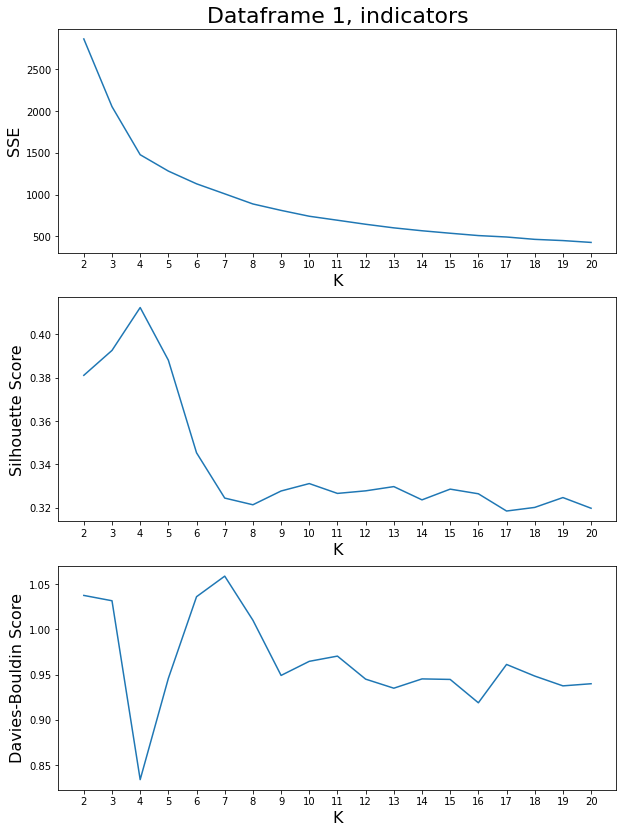

In [ ]:
plot_indicators(1, 20, sse_clusters[1], sil_clusters[1], davies_clusters[1])  # ["p_w_Hard", "p_w_Clay", "p_w_Grass"]

By using the elbow rule on the SSE graph and by looking at the others we choose 4 as the best number of clusters.

In [ ]:
k = 4  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[1])
print("SSE:",sse_clusters[1][k-2]," - SILHOUETTE:",sil_clusters[1][k-2])

SSE: 1477.8687207995163  - SILHOUETTE: 0.41244714663768733


##### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Text(255    3.29926
Name: PC_1, dtype: float64, 255   -0.286712
Name: PC_2, dtype: float64, 'novak djokovic')

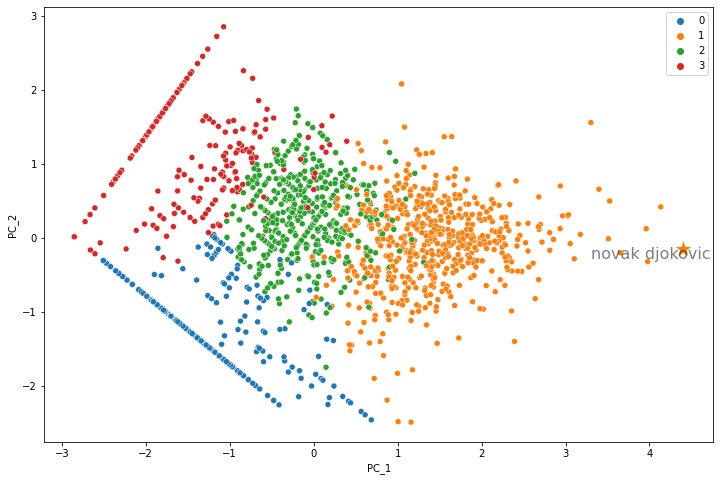

In [ ]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[1]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-1.1, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

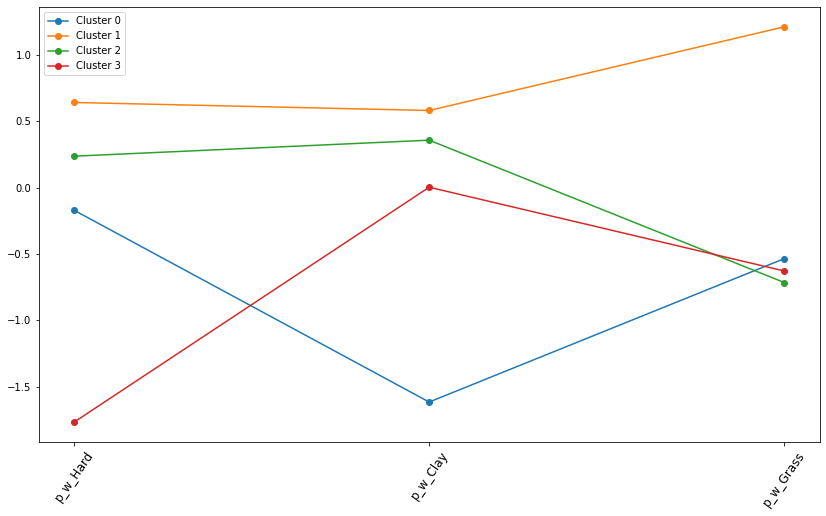

In [ ]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[1], clusters_players, df_clusters_scaled[1].columns)

The only meaningful information is that cluster 1 contains those player called "all-rounder" and most of the best players fall within this cluster.

In [ ]:
df_cluster_plot = df_clusters[1].copy()
df_cluster_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,p_w_Hard,p_w_Clay,p_w_Grass
cluster,,,
0,38.873839,3.390903,6.380645
1,52.603989,49.636534,50.833953
2,45.761506,44.926205,1.803193
3,11.877395,37.463697,4.017395


The means we calculated for each clusters confirm our assumptions on the clusters (i.e.: cluster 1 contains the best current players).

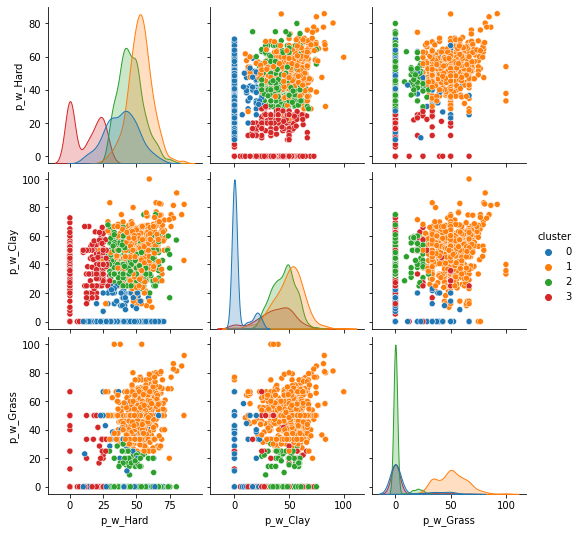

In [ ]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

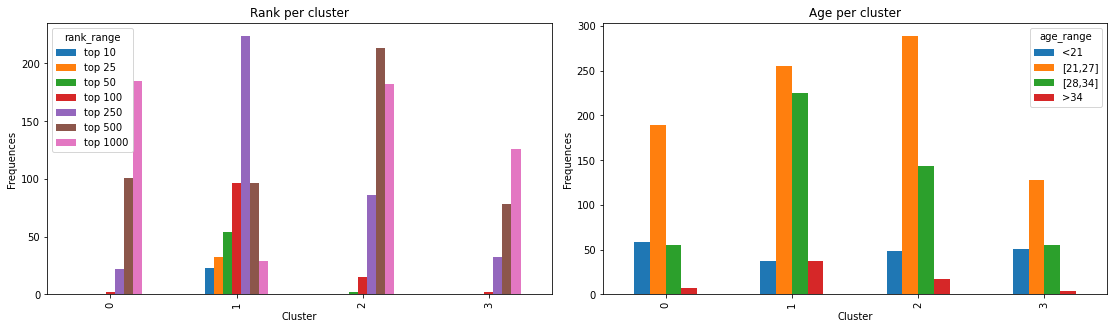

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

As expected the best players are in the "all-rounder" cluster, the other players are more or less distributed in the other clusters.

#### **Clustering on the third dataframe ["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won"]**

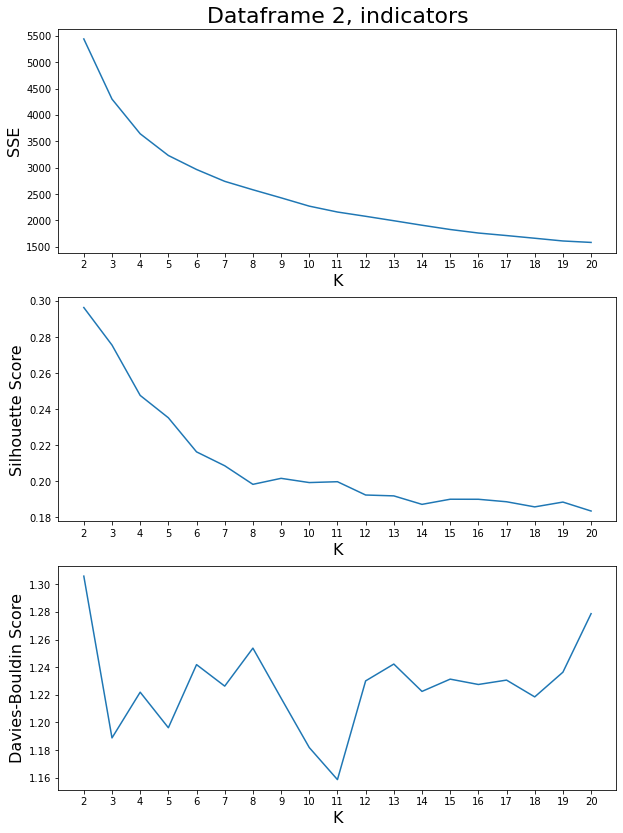

In [ ]:
plot_indicators(2, 20, sse_clusters[2], sil_clusters[2], davies_clusters[2])  # ["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won", "mean_sv_points"]

By using the elbow rule on the SSE graph and by looking at the others we choose 3 as the best number of clusters.

In [ ]:
k = 3  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[2])
print("SSE:",sse_clusters[2][k-2]," - SILHOUETTE:",sil_clusters[2][k-2])

SSE: 4302.6719294397635  - SILHOUETTE: 0.2755724970328096


##### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Text(255   -3.473006
Name: PC_1, dtype: float64, 255   -1.65676
Name: PC_2, dtype: float64, 'novak djokovic')

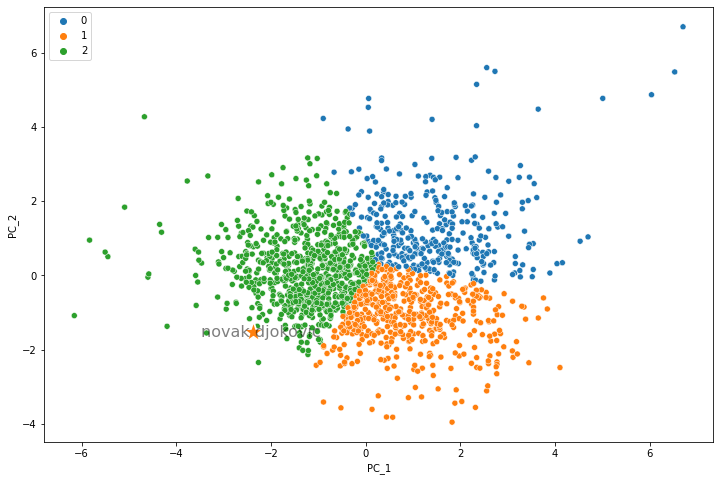

In [ ]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[2]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-1.1, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

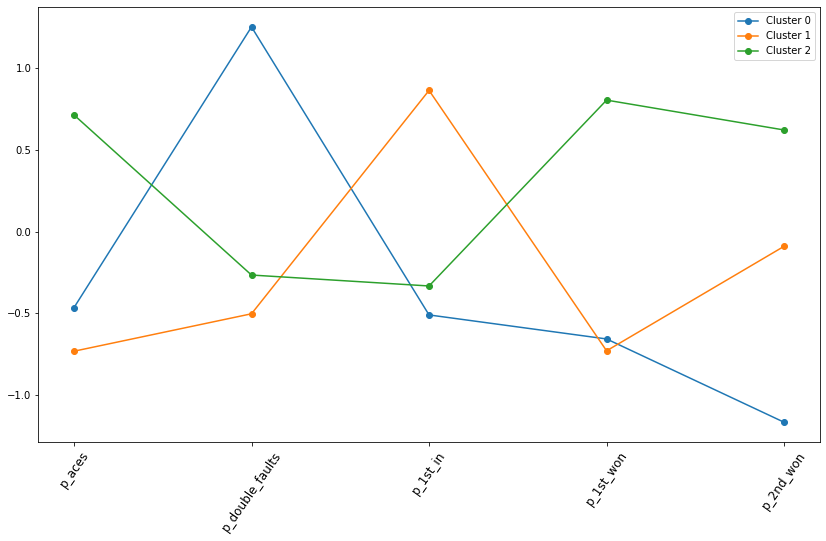

In [ ]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[2], clusters_players, df_clusters_scaled[2].columns)

The more left on the PCA analysis a player is, the more his/her playstyle is based on aces with an high percentage of success (cluster 2). Cluster 1 is formed by those players with a minimum risk approach on serves (hence the minimum double faults) meanwhile cluster 0 is formed by those that take many risks while serving (hence the high number of double faults).

In [ ]:
df_cluster_plot = df_clusters[2].copy()
df_cluster_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,p_aces,p_double_faults,p_1st_in,p_1st_won,p_2nd_won
cluster,,,,,
0,3.664050,7.054358,58.826620,62.587095,42.735782
1,2.848032,3.916687,64.876526,62.192731,46.918675
2,7.274462,4.340457,59.606801,70.534449,49.682258


It's not safe to assume that the best players belong to cluster 1, since they may have different playstyles between them.

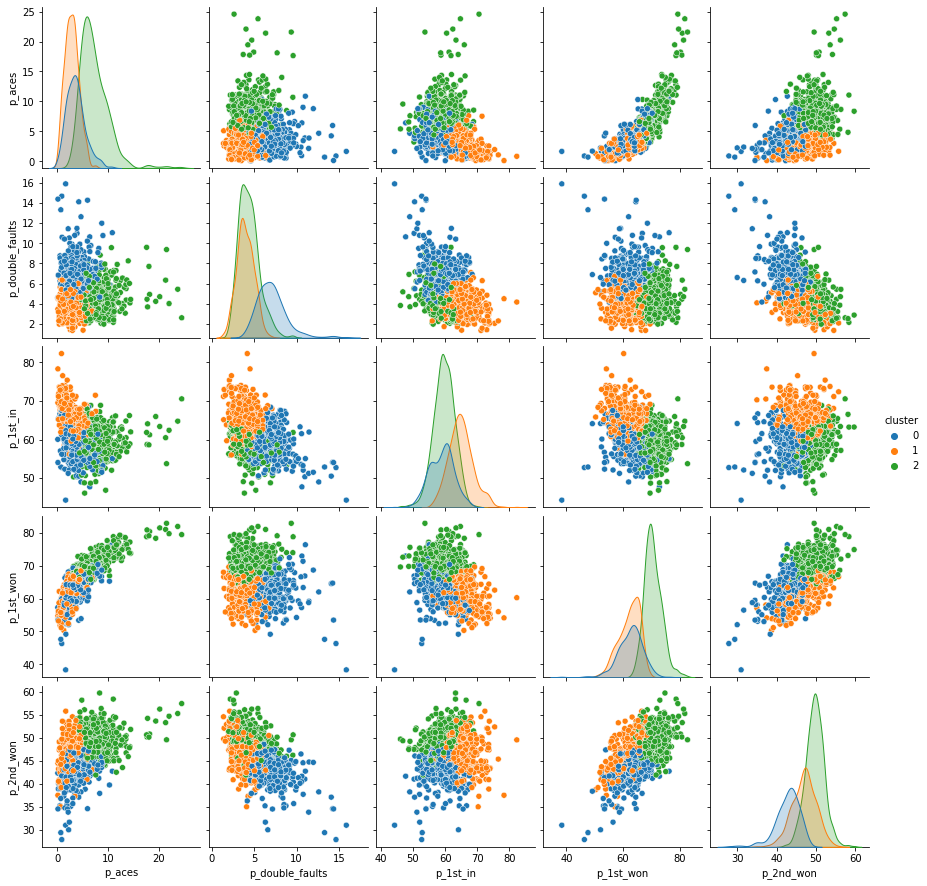

In [ ]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

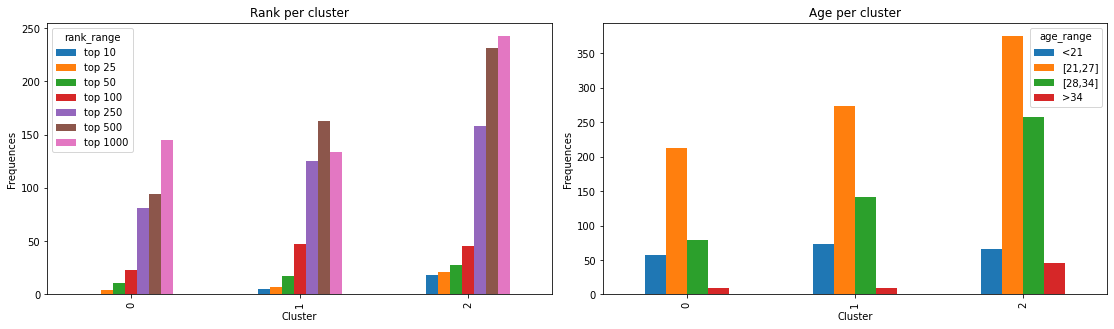

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

It seems that the best players don't have a very aggressive playstyle while serving, still they are very efficient of doing aces.

## **Centroids**

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_centr = pd.DataFrame(centers, columns=df_clust_selected.columns)
df_centr

ValueError: ignored

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
#fig, axs = plt.subplots(2,2,figsize=(15,15))

label_s = 12
feat1 = 'mean_svPt'
feat2 = 'mean_aces'
col1, i1 = df_clust_selected[feat1], df_clust_selected.columns.get_loc(feat1)
col2, i2 = df_clust_selected[feat2], df_clust_selected.columns.get_loc(feat2)
xlim = df_clust_selected[feat1].max()
ylim = df_clust_selected[feat2].max()
offsetx = df_clust_selected[feat1].max()/20
offsety = df_clust_selected[feat2].max()/20

fig = plt.figure(figsize=(10,8))

plt.scatter(col1, col2, c=kmeans.labels_, s=20)
plt.scatter(centers[:, i1], centers[:, i2], s=100, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.ylabel(df_clust_selected.columns[i2], fontsize=label_s)
plt.xlabel(df_clust_selected.columns[i1], fontsize=label_s)

In [ ]:
df_clust_selected_stand

In [ ]:
from math import pi

centers = kmeans.cluster_centers_
# number of variable
N = len(df_clust_selected_stand.columns) - 1

plt.figure(figsize = (8,8))
label_s = 12

for i in range(0,len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], df_clust_selected_stand.columns, color='grey', size=label_s) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
# Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

In [ ]:
df_clust

In [ ]:
df_clust.loc['roger federer']

## **DB-scan**
We now perform the DBSCAN clustering algorithm.

We decided to work only the first dataframe from the k-means analysis (the one with ["t_won", "p_wins", "rank"]) since we think that describes better which describes better which ones are the best players and which aren't, the work we'll follow the same flow as the k-means.

In [ ]:
df_clustering_dbscan = df_clusters[0].copy()
x_dbscan = scaler.fit_transform(df_clustering_dbscan.values)
df_clustering_dbscan_scaled = pd.DataFrame(x_dbscan, columns=df_clustering_dbscan.columns, index=df_players.index)

###**Grid search for min_samples and eps**

We choose the best hyperparameters for the dbscan by using the grid search on some possible values for both min_samples and eps. We want to underline the fact that what you see in this notebook is just the final range of which we tried the grid search, we pruned all the other values for the hyperparameters.

In [319]:
k_grid = np.arange(2, 10)
eps_grid = np.round(np.linspace(0.9, 1.4, 11), 2)
print("Parameters for the grid search:\nmin_samples: {0}\neps: {1}".format(k_grid, eps_grid))

Parameters for the grid search:
min_samples: [2 3 4 5 6 7 8 9]
eps: [0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4 ]


In [320]:
df_clusters_grid = pd.DataFrame(np.zeros((len(eps_grid), len(k_grid))), index=eps_grid, columns=k_grid)
df_sil_grid = pd.DataFrame(np.zeros((len(eps_grid), len(k_grid))), index=eps_grid, columns=k_grid)
for k in tqdm(k_grid):
    for eps in eps_grid:
        dbscan = DBSCAN(eps=eps, min_samples=k)
        dbscan.fit(x_dbscan)
        df_clusters_grid.loc[eps, k] = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))
        df_sil_grid.loc[eps, k] = silhouette_score(x_dbscan, dbscan.labels_)

  0%|          | 0/8 [00:00<?, ?it/s]

Let's plot the results of the grid search, keep in mind that for the number of clusters the outliers are not counted.

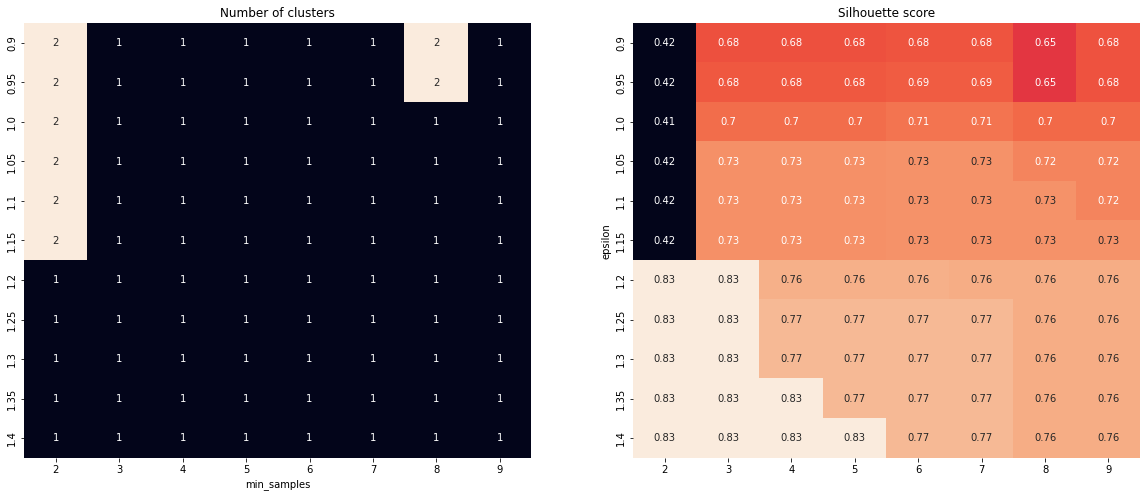

In [321]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sn.heatmap(df_clusters_grid, annot=True, ax=axs[0], cbar=False).set_title("Number of clusters")
sn.heatmap(df_sil_grid, annot=True, ax=axs[1], cbar=False).set_title("Silhouette score")
axs[0].set_xlabel("min_samples")
axs[0].set_xlabel("min_samples")
axs[1].set_ylabel("epsilon")
axs[1].set_ylabel("epsilon")
plt.show()

After trying some combinations of min_samples and eps we decided to take min_samples = 3 and eps= 0.9.

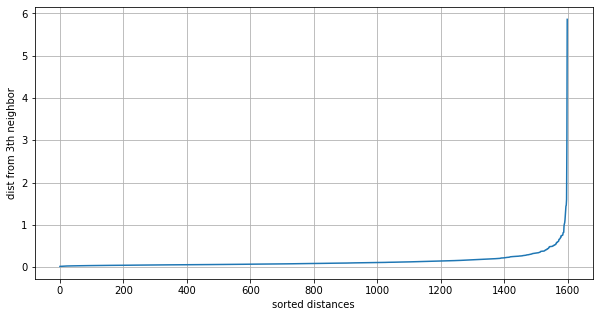

In [336]:
dist = pdist(x_dbscan, 'euclidean')  # pair wise distance
dist = squareform(dist)  # distance matrix given the vector dist
print()

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[3]
    kth_distances.append(d[index_kth_distance])
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % 3)
plt.xlabel('sorted distances')
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()    

As we can see with eps 0.9 the graph has the maximum curvature, so our choice was right.

###**Clustering**

Perform the dbscan algorithm.

In [333]:
k = 3
eps = 1.1
dbscan = DBSCAN(eps=eps, min_samples=k)
dbscan.fit(x_dbscan)

DBSCAN(algorithm='auto', eps=1.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

In [334]:
print('Silhouette %s' % silhouette_score(x_dbscan, dbscan.labels_))

Silhouette 0.7326041911110275


Plot the clusters by using the PCA.

Text(255    6.530078
Name: PC_1, dtype: float64, 255    8.542943
Name: PC_2, dtype: float64, 'novak djokovic')

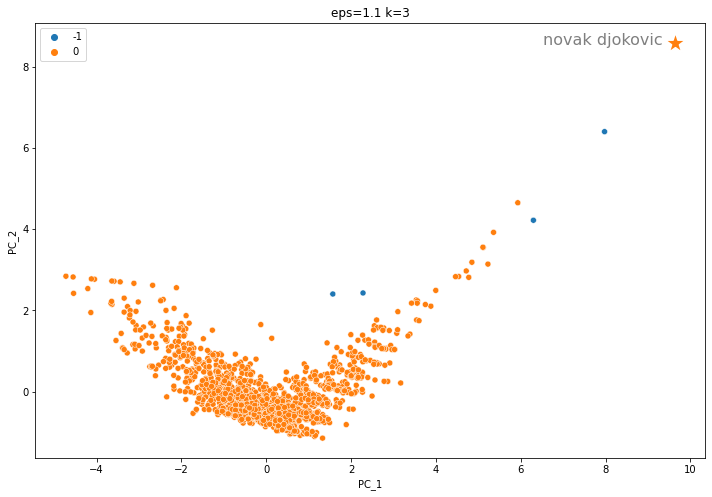

In [335]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_dbscan), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(dbscan.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title(label="eps=" + str(eps) + " k=" + str(k))

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

The outliers are those players who won a large amount of tournaments and therefore are the best, let's see who are them.

In [337]:
df_cluster_plot = df_clustering_dbscan.copy()
df_cluster_plot["cluster"] = dbscan.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,t_won,p_wins,rank
cluster,,,
-1,15.200000,75.206000,291.000000
0,0.856426,44.270771,450.223824


In [338]:
index = df_cluster_plot[df_cluster_plot["cluster"]==-1].index
df_players.loc[index]

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
52,roger federer,M,39,CHE,185,R,15,83.41,186,84.03,121,75.00,15,84.75,50,11.07,2.16,63.22,50,78.78,39,58.38,17,79,68.34,2,4,8,4815,>34,"[181,190]",top 10
101,yen hsun lu,M,37,TWN,180,R,7,62.99,80,62.50,65,0.00,0,75.00,15,7.70,3.92,61.25,42,74.00,31,53.91,14,69,59.65,2,4,625,45,>34,"[171,180]",top 1000
205,rafael nadal,M,35,ESP,185,L,21,84.64,259,80.25,126,90.23,120,81.25,13,4.86,2.53,66.53,49,73.04,36,58.15,14,74,68.00,3,4,3,8270,"[28,34]","[181,190]",top 10
255,novak djokovic,M,34,SRB,188,R,27,85.45,282,85.86,164,82.18,83,92.11,35,6.84,3.23,65.46,51,74.58,38,55.49,14,77,65.65,3,4,1,12113,"[28,34]","[181,190]",top 10
509,gerald melzer,M,31,AUT,191,L,6,59.54,103,48.15,13,61.64,90,0.00,0,5.33,3.59,63.49,44,68.98,30,52.52,13,69,60.12,3,6,818,22,"[28,34]","[181,190]",top 1000


Our assumption was correct, the outliers are formed by the four best current players and two players (Yen Hsun Lu and Gerald Melzer) who won smaller tournaments and for such reason they appear in the cluster.

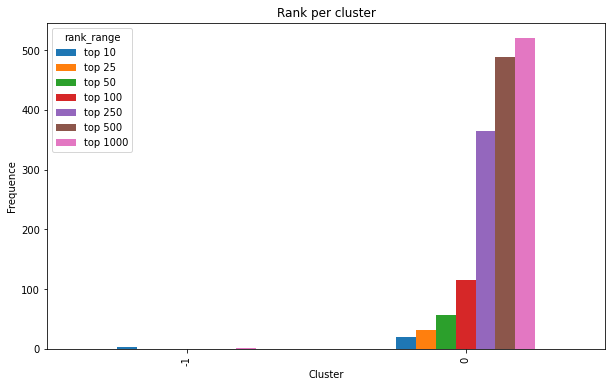

In [339]:
rank_xt_pct = pd.crosstab(dbscan.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

## **Hierarchical**

As last algorithm we will use the hierarchical clustering with its differents methods.

In [ ]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
df_clustering_hier = df_clusters[0].copy()
x_hier = scaler.fit_transform(df_clustering_hier.values)
df_clustering_hier_scaled = pd.DataFrame(x_hier, columns=df_clustering_hier.columns, index=df_players.index)

Method for plotting the graphs of the hierarchical clustering, taken from the scikit-learn official website.

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

###**Complete**

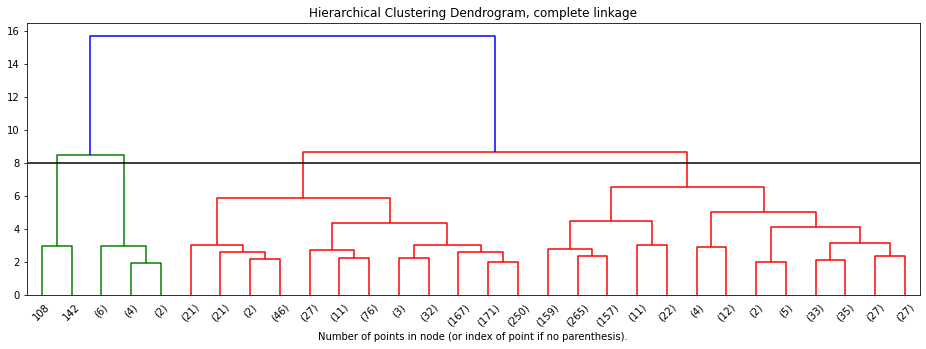

In [ ]:
hier_complete = AgglomerativeClustering(distance_threshold=8, n_clusters=None, linkage="complete")
hier_complete = hier_complete.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, complete linkage")
plot_dendrogram(hier_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=8, color="black")

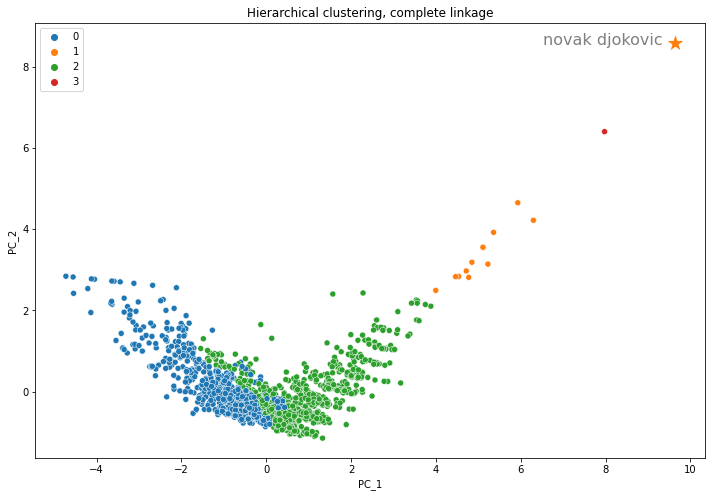

In [ ]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_complete.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, complete linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

The information we can retrieve from the previous graph is that hierarchical clustering has separated the cluster with the best players seen in k-means in two clusters, one with the best players and the other with the two best players overall.

In [ ]:
hist, bins = np.histogram(hier_complete.labels_, bins=range(0, len(set(hier_complete.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_complete.labels_))

{0: 759, 1: 12, 2: 827, 3: 2}
Silhouette 0.3082379849287149


In [ ]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_complete.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,t_won,p_wins,rank
cluster,,,
0,0.050066,34.154084,642.932806
1,12.416667,71.683333,15.000000
2,1.459492,53.246276,279.796856
3,24.000000,85.045000,2.000000


Let's show the two overall best players.

In [ ]:
index = df_cluster_plot[df_cluster_plot["cluster"]==3].index
df_players.loc[index]

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
205,rafael nadal,M,35,ESP,185,L,21,84.64,259,80.25,126,90.23,120,81.25,13,4.86,2.53,66.53,49,73.04,36,58.15,14,74,68.00,3,4,3,8270,"[28,34]","[181,190]",top 10
255,novak djokovic,M,34,SRB,188,R,27,85.45,282,85.86,164,82.18,83,92.11,35,6.84,3.23,65.46,51,74.58,38,55.49,14,77,65.65,3,4,1,12113,"[28,34]","[181,190]",top 10


In [ ]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")

Plot the pairwise correlations between the considered features.

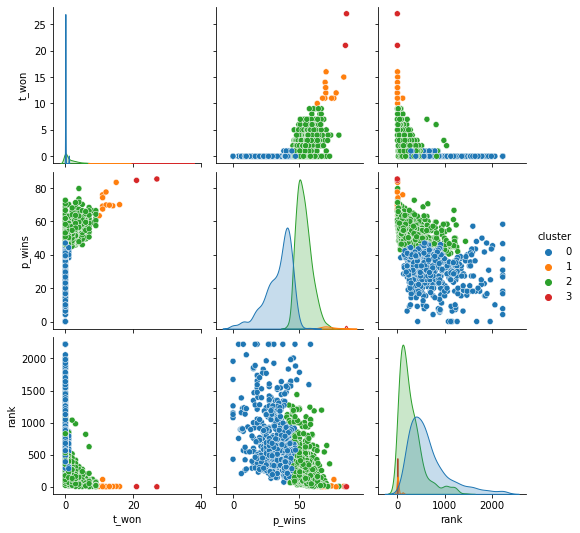

In [ ]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

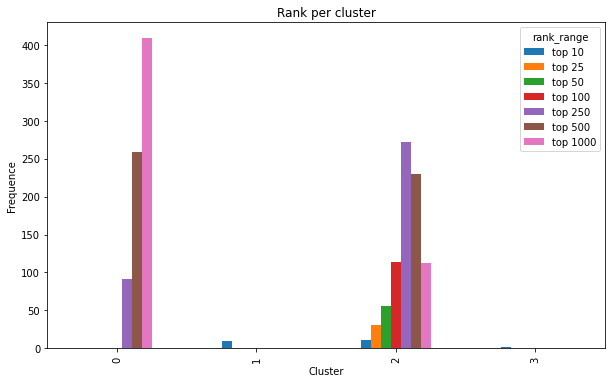

In [ ]:
rank_xt_pct = pd.crosstab(hier_complete.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

As expected the the top 10 players are in the same cluster (labeled with 1), meanwhile the extremely best players are in another one (labeled with 3).

###**Single**

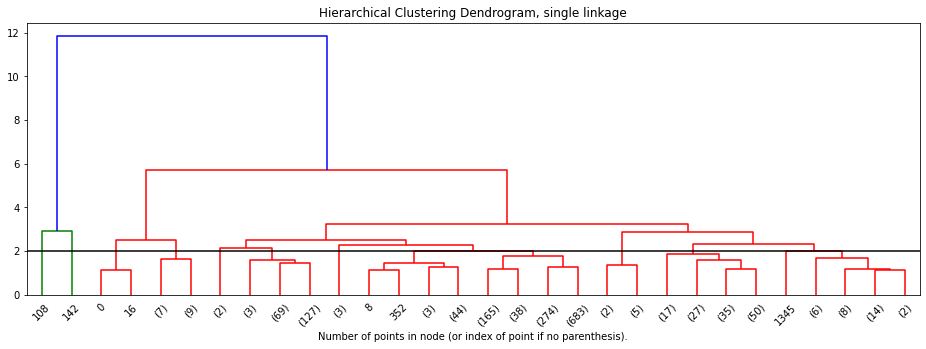

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_single = AgglomerativeClustering(distance_threshold=2, n_clusters=None, linkage="single")
hier_single = hier_single.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, single linkage")
plot_dendrogram(hier, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=2, color="black")

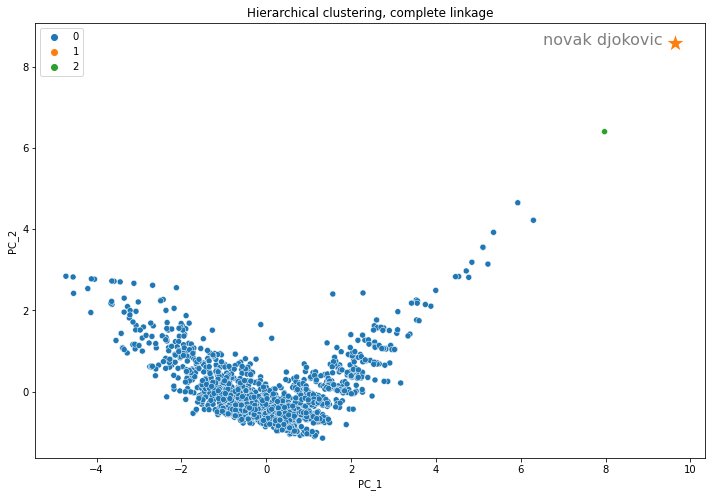

In [ ]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_single.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, complete linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

This time the clustering is extremely underwhelming, we have three cluster and two of them consist of just one player each, albeit those players are the two best overall as we've seen in the complete linkage method.

In [ ]:
hist, bins = np.histogram(hier_single.labels_, bins=range(0, len(set(hier_single.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_single.labels_))

{0: 1598, 1: 1, 2: 1}
Silhouette 0.8012613600098762


In [ ]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_single.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,t_won,p_wins,rank
cluster,,,
0,0.87234,44.316533,450.286608
1,27.00000,85.450000,1.000000
2,21.00000,84.640000,3.000000


In [ ]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")

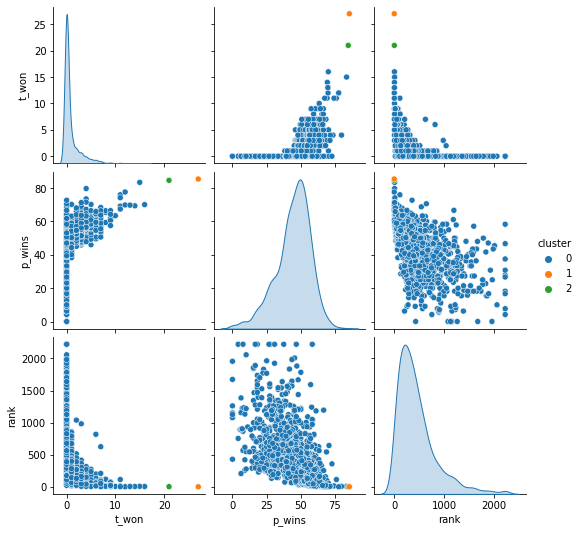

In [ ]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

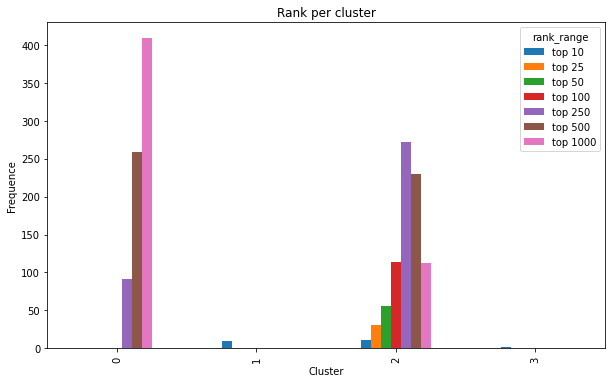

In [ ]:
rank_xt_pct = pd.crosstab(hier_complete.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

###**Average**

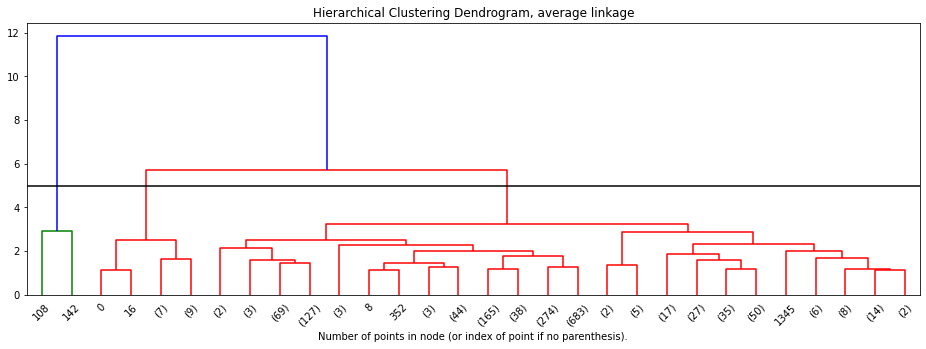

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_average = AgglomerativeClustering(distance_threshold=5, n_clusters=None, linkage="average")
hier_average = hier_average.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, average linkage")
plot_dendrogram(hier, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=5, color="black")

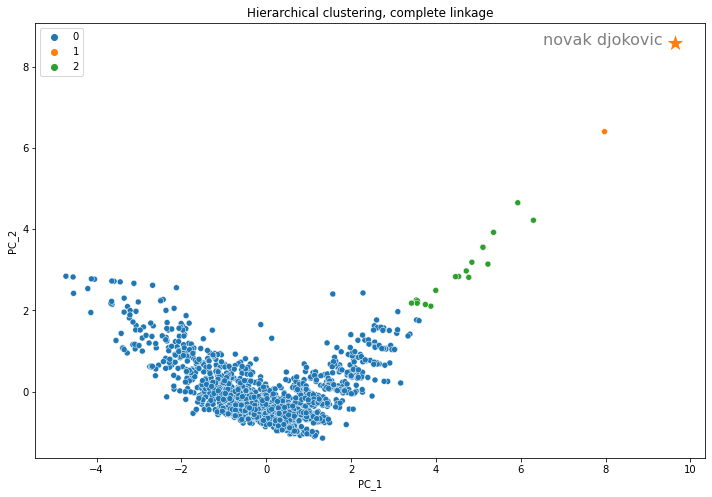

In [ ]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_average.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, complete linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

In [ ]:
hist, bins = np.histogram(hier_average.labels_, bins=range(0, len(set(hier_average.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_average.labels_))

{0: 1580, 1: 2, 2: 18}
Silhouette 0.6484604763817379


In [ ]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_complete.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

,t_won,p_wins,rank
cluster,,,
0,0.050066,34.154084,642.932806
1,12.416667,71.683333,15.000000
2,1.459492,53.246276,279.796856
3,24.000000,85.045000,2.000000


The average linkage gives similar results to the complete one, there's no point in showing everyhitng again.

##**Other clusterings**

We explore two more clustering approaches by using the pyclustering library.

Install and import the package.

In [255]:
!pip install pyclustering
import pyclustering

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=e9943ae9afe0da2760720cb2d462a4f42954b4329eab3f1d88f8404d52922e81
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering
